**ECSE 422 Project**

**Team Members:**

*   Shabthana Kandasamy - 260927788
*   Ping Gu - 260446005
*   Rambod Azimi - 260911967

**Part 1: Exhaustive Enumeration**

**Implementation**

1.   Read the input text file, extract information, and store to their corresponding variables (*N, reliability_matrix, cost_matrix*). To do so, we have implemented a function called *read_numbers_from_file()* which takes a filename as input, reads the file line by line, ignores lines starting with # (comments), extracts N from the first line, reads the remaining numbers into a list, and finally stores the values in their corresponding variables.

2.   Determine all possible network combinations by generating binary numbers with N*(N-1)/2 *italicized text* bits. Given N nodes, we can have 2^(N*(N-1)/2) *italicized text* possible combinations. Therefore, a binary number with that number of digits could cover all possible combinations. We do so by implementing the *generate_binary_numbers()* function. We store all combinations in the *binary_numbers* list.

3. Not all possible combinations are feasible. For example, some combinations do not result in a connected network. To eliminate these combinations, we check whether the created network is connected or not. First, we convert each binary number (representing an *edge list*) into an *adjacency list* by calling the function *binary_to_adjacency()*. This function returns a list called *adj_matrix*, which is then used as input for another function named *is_connected()*. The is_connected() function runs the *Depth-First Search* (DFS) algorithm to determine whether the connected components can traverse all the nodes within the network or not.

4. We iterate over all possible combinations (*binary_numbers*) and eliminate ones that are not connected, and store the remaining to another list called *connected_numbers*.

5. We further eliminate combinations that exceed the cost limit. Given an integer number *cost_limit*, we calculate the total cost of the network using the *calculate_total_cost()* function. If the calculated cost exceeds the cost limit, we remove the combination from the list. This is achieved by iterating over each digit of each remaining binary number, adding the corresponding cost if the digit is '1'. The remaining combinations are then stored in a new list called *feasible_numbers*.

6. Now that we have a set of all possible networks that are both connected and do not exceed the cost limit, represented by their binary numbers (feasible_numbers), we start calculating the reliability of each network in order to find the highest reliability. To do so, we implement the following functions:

*   *calculate_single_reliability()*: Given a network represented by its binary number, we calculate the reliability by multiplying the edges that are connected in the graph. This function is used only when our network is a spanning tree (with no redundancy), so that the total reliability is a simple multiplication of all edge reliabilities.

*   *calculate_reliability()*: Given a network represented by its binary number, we calculate the reliability by considering redundancies as well. If there's only one redundancy (i.e., the number of edges = N), we use *generate_variations()* to generate any possible sub-network from that network that is still possible. By combining all those generated sub-networks and summing up the reliability values, we calculate the total reliability of that network with one redundancy.

*   *generate_variations()*: Given a network (represented by its binary edge list), generate all possible sub-networks with 1 edge less.

*   *generate_variations_all()*: Given a network represented by its binary edge list, we aim to generate all possible sub-networks with two or more edges removed. We achieve this by recursively calling the function on each generated variation until we have combined all possible sub-networks while respecting the connectivity constraint. Then, we flatten the list, remove any duplicates, and return the final result.

7. We store the calculated reliabilities in a list named *reliabilities*.

8. We find the highest reliability by sorting the reliabilities list and returning the first element.

9. Finally, we print important results for the network design.

10. For the interesting feature, we implement a simple GUI representation of the selected network graph with the highest reliability.


In [297]:
# This function reads the input files and stores the information into their corresponding variables
def read_numbers_from_file(filename):
  numbers = []

  with open(filename, 'r') as file:
    lines = file.readlines()

    # Filter out comment lines and strip whitespace
    lines = [line.strip() for line in lines if not line.strip().startswith("#")]

    # Extract N from the first line
    N = int(lines[0])

    # Read the remaining numbers into the list
    for line in lines[1:]:
      numbers.extend(map(float, line.split()))

  # Create 2 lists for storing reliability and cost values
  reliability_matrix = []
  cost_matrix = []

  # Iterate over all values and store them into the lists
  for i in range(N*(N-1)//2):
    reliability_matrix.append(numbers[i])
    cost_matrix.append(numbers[(N*(N-1)//2) + i])

  return N, reliability_matrix, cost_matrix

filename = "6_city.txt"
N, reliability_matrix, cost_matrix = read_numbers_from_file(filename)
# Maximum cost for the network
cost_limit = 85

print("N:", N)
print("Reliability Matrix:", reliability_matrix)
print("Cost Matrix:", cost_matrix)

N: 6
Reliability Matrix: [0.94, 0.91, 0.96, 0.93, 0.92, 0.94, 0.97, 0.91, 0.92, 0.94, 0.9, 0.94, 0.93, 0.96, 0.91]
Cost Matrix: [10.0, 25.0, 10.0, 20.0, 30.0, 10.0, 10.0, 25.0, 20.0, 20.0, 40.0, 10.0, 20.0, 10.0, 30.0]


In [298]:
# TIMER FOR EXHAUSTIVE SEARCH
import time
start_time_exhaustive = time.time()

In [299]:
# This function generates a list of binary digit representing edge lists
def generate_binary_numbers(n):
    max_num = 2 ** (n * (n - 1) // 2)
    binary_numbers = []
    for i in range(max_num):
        binary_numbers.append(bin(i)[2:].zfill(n * (n - 1) // 2))
    return binary_numbers

binary_numbers = generate_binary_numbers(N)
print(f"{len(binary_numbers)} possible combinations when N = {N}.")

32768 possible combinations when N = 6.


In [300]:
# This function converts the edge matrix (binary representation) into an adjacency matrix
def binary_to_adjacency(binary_digit):
    n = N
    adjacency_matrix = [[0] * n for _ in range(n)]  # Initialize adjacency matrix with zeros
    idx = 0
    for i in range(n):
        for j in range(i+1, n):
            adjacency_matrix[i][j] = int(binary_digit[idx])  # Fill upper triangular part
            adjacency_matrix[j][i] = int(binary_digit[idx])  # Fill lower triangular part (graph is undirected)
            idx += 1
    return adjacency_matrix

# This function determines if a network (represented by its adjacency matrix) is connected or not
def is_connected(adj_matrix):
    def dfs(node, visited):
        visited[node] = True
        for neighbor, connected in enumerate(adj_matrix[node]):
            if connected and not visited[neighbor]:
                dfs(neighbor, visited)

    n = len(adj_matrix)
    visited = [False] * n
    dfs(0, visited)

    # If any node remains unvisited, the graph is not connected
    return all(visited)

In [301]:
# Out of all possible combinations we have for network design, some of them are infeasible as the network would not be connected.
# Therefore, we eliminate those combinations that do not make a connected network

connected_numbers = [] # Valid combinations that create a connected network
for binary in binary_numbers:
  adj_matrix = binary_to_adjacency(binary)
  if (is_connected(adj_matrix)):
    connected_numbers.append(binary)

print(f"{len(connected_numbers)} possible combinations out of {len(binary_numbers)} total combinations are connected.")

26704 possible combinations out of 32768 total combinations are connected.


In [302]:
# Eliminate combinations that exceed the cost limit
# This function calculates the total cost of a given network
def calculate_total_cost(binary):
  total_cost = 0
  for digit in range(len(binary)):
    if binary[digit] == "1":
      total_cost += cost_matrix[digit]
  return total_cost

feasible_numbers = []
for binary in connected_numbers:
  cost = calculate_total_cost(binary)
  if cost <= cost_limit:
    feasible_numbers.append(binary)

print(f"{len(feasible_numbers)} possible combinations out of {len(binary_numbers)} total combinations are feasible (connected and cost <= {cost_limit})")

547 possible combinations out of 32768 total combinations are feasible (connected and cost <= 85)


In [303]:
# This will print all the feasible networks respecting both connectiveness and cost limit
for binary in feasible_numbers:
  print(f"{binary} has a total cost of {calculate_total_cost(binary)}")

000010100001110 has a total cost of 80.0
000010110001010 has a total cost of 85.0
000011000001110 has a total cost of 80.0
000011010001010 has a total cost of 85.0
000011100000110 has a total cost of 80.0
000011100001100 has a total cost of 80.0
000011110000010 has a total cost of 85.0
000011110001000 has a total cost of 85.0
000100001001110 has a total cost of 80.0
000100010001110 has a total cost of 85.0
000100011001010 has a total cost of 85.0
000100100001011 has a total cost of 80.0
000100100001110 has a total cost of 70.0
000100100100110 has a total cost of 80.0
000100100101100 has a total cost of 80.0
000100101001100 has a total cost of 80.0
000100110001010 has a total cost of 75.0
000100110100010 has a total cost of 85.0
000100110101000 has a total cost of 85.0
000100111001000 has a total cost of 85.0
000101000001011 has a total cost of 80.0
000101000001110 has a total cost of 70.0
000101000100110 has a total cost of 80.0
000101000101100 has a total cost of 80.0
000101001000110 

In [304]:
# Given a network (represented by its binary edge list), generate all possible sub-networks with 1 edge less
def generate_variations(binary_str):
    variations = [binary_str]

    for i in range(len(binary_str)):
        if binary_str[i] == '1':
            variation = binary_str[:i] + '0' + binary_str[i+1:]
            if(variation.count("1") >= (N-1) and is_connected(binary_to_adjacency(variation))):
              variations.extend(generate_variations(variation))

    return variations

# Given a network (represented by its binary edge list), generate all possible networks with 2 or more edges less
def generate_variations_all(binary):
  variations = [binary]

  for i in range(len(binary)):
    if binary[i] == '1':
      variation = binary[:i] + '0' + binary[i+1:]
      if(variation.count("1") >= (N-1) and is_connected(binary_to_adjacency(variation))):
        variations.extend(generate_variations(variation))
  variations.pop(0)

  big_list = []
  big_list.append(variations)

  for bin in variations:
    if(bin.count("1") > (N-1)):
      big_list.append(generate_variations(bin))

  flattened_list = [element for sublist in big_list for element in sublist]
  unique_combinations = []

  for combination in flattened_list:
    if combination not in unique_combinations:
        unique_combinations.append(combination)

  return unique_combinations

In [305]:
# Use a Brute-force method to calculate the network reliability of each feasible network and find the highest reliability
def calculate_single_reliability(binary, org):
  reliability = 1.0
  for digit in range(len(binary)):
    if binary[digit] == "1":
      reliability *= reliability_matrix[digit]
    else:
      if(org[digit] == "1"):
        reliability *= (1 - reliability_matrix[digit])
  return reliability

def calculate_reliability(binary):
  if(binary.count('1') == N-1): # if the network is a spanning tree (no redundancy)
    reliability = 1.0
    for digit in range(len(binary)):
      if binary[digit] == "1":
        reliability *= reliability_matrix[digit]
    return reliability

  elif(binary.count('1') == N): # if we have 1 redundency
    reliability = 0.0
    possible_networks = generate_variations(binary) # generate all feasible combinations
    for network in possible_networks:
      reliability += calculate_single_reliability(network, binary) # add up the reliabilities
    return reliability

  else: # more than 1 redundancy
    reliability = 0.0
    possible_networks = generate_variations_all(binary) # generate all feasible combinations
    possible_networks.append(binary)
    for network in possible_networks:
      reliability += calculate_single_reliability(network, binary) # add up the reliabilities
    return reliability

reliabilities = []
for binary in feasible_numbers:
  reliabilities.append(calculate_reliability(binary))

In [306]:
# Printing all results
print("Summary of the network design using Exhaustive Enumeration:\n")

print("N:", N)
print("Reliability Matrix:", reliability_matrix)
print("Cost Matrix:", cost_matrix)
print("Cost Limit:", cost_limit)

print(f"{len(binary_numbers)} possible combinations when N = {N}.")
print(f"{len(feasible_numbers)} possible combinations out of {len(binary_numbers)} total combinations are feasible (connected and cost <= {cost_limit})")

# Finding the highest Reliability
max_reliability = 0.0
for r in range(len(reliabilities)):
  if reliabilities[r] > max_reliability:
    max_reliability = reliabilities[r]
    feas = feasible_numbers[r]

for r in range(len(reliabilities)):
  print(f"{r+1}: {feasible_numbers[r]} has a reliability {reliabilities[r]} and cost {calculate_total_cost(feasible_numbers[r])}")

print(f"\nHighest Reliability: {max_reliability} with cost {calculate_total_cost(feas)} and binary value {feas}")


Summary of the network design using Exhaustive Enumeration:

N: 6
Reliability Matrix: [0.94, 0.91, 0.96, 0.93, 0.92, 0.94, 0.97, 0.91, 0.92, 0.94, 0.9, 0.94, 0.93, 0.96, 0.91]
Cost Matrix: [10.0, 25.0, 10.0, 20.0, 30.0, 10.0, 10.0, 25.0, 20.0, 20.0, 40.0, 10.0, 20.0, 10.0, 30.0]
Cost Limit: 85
32768 possible combinations when N = 6.
547 possible combinations out of 32768 total combinations are feasible (connected and cost <= 85)
1: 000010100001110 has a reliability 0.7489306367999999 and cost 80.0
2: 000010110001010 has a reliability 0.7328246016 and cost 85.0
3: 000011000001110 has a reliability 0.7257678336 and cost 80.0
4: 000011010001010 has a reliability 0.7101599231999999 and cost 85.0
5: 000011100000110 has a reliability 0.7489306367999999 and cost 80.0
6: 000011100001100 has a reliability 0.7333279152 and cost 80.0
7: 000011110000010 has a reliability 0.7328246015999998 and cost 85.0
8: 000011110001000 has a reliability 0.7175574223999999 and cost 85.0
9: 000100001001110 has a 

In [307]:
# END OF TIMER FOR EXHAUSITVE SEARCH
end_time_exhaustive = time.time()

total_time_exhaustive = end_time_exhaustive - start_time_exhaustive
print("Execution time for exhaustive search:", total_time_exhaustive * 100, "ms")


Execution time for exhaustive search: 95.65060138702393 ms


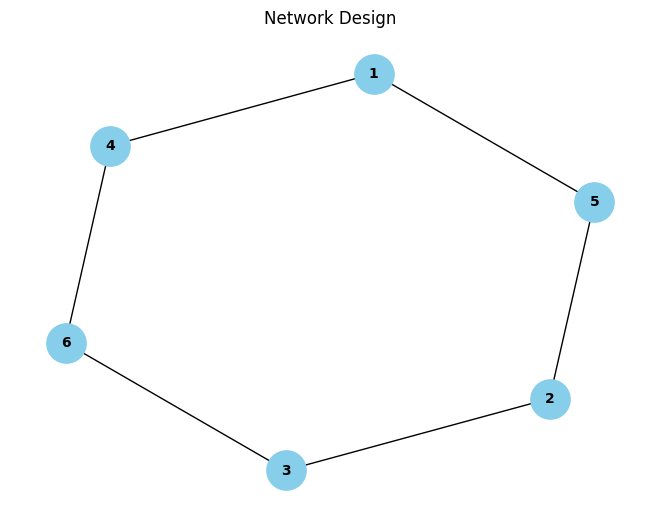

In [308]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_graph(N, binary_edge_list):
    if(binary_edge_list == ""):
      return
    # Create an empty graph
    G = nx.Graph()

    # Add nodes to the graph
    for node in range(N):
        G.add_node(node)

    # Convert binary edge list to list of tuples representing edges
    edges = []
    idx = 0
    for i in range(N):
        for j in range(i+1, N):
            if binary_edge_list[idx] == '1':
                edges.append((i+1, j+1))
            idx += 1

    # Add edges to the graph
    G.add_edges_from(edges)
    G.remove_node(0)

    # Draw the graph
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=800, font_size=10, font_weight='bold')
    plt.title('Network Design')
    plt.show()

plot_graph(N, feas)


**Part 2: Efficient Algorithm**

In [309]:
# TIMER FOR EFFICIENT SEARCH
import time
start_time_efficient = time.time()

In [310]:
#create list of every possible edges along with it's cost and reliability
#return tuple list of 3 items:
#1st is nodes of edge
#2nd is cost edge
#3rd is 1 - reliability of the edge, for easier sorting
def create_edge_info_list(cost_matrix, reliability_matrix):
  edge_info_list = []
  start = 1
  j = start + 1
  for i in range(len(cost_matrix)) :
    edge_info_list.append(((start, j), cost_matrix[i], 1-reliability_matrix[i]))
    j += 1
    if j > N:
      start += 1
      j = start + 1
  return edge_info_list

#find reliability of enhanced network reliability
def find_enhanced_reliability(edges_list, sorted_list) :
  binary_digits = ['0'] * len(reliability_matrix)
  for i in edges_list :
    curr_edge = sorted_list[i][0]
    starting_index = 0
    for j in range(curr_edge[0]-1) :
      starting_index += (N-j-1)
    curr_index = starting_index + (curr_edge[1] - curr_edge[0] - 1)
    binary_digits[curr_index] = '1'
  binary = ''.join(binary_digits)
  reliability = calculate_reliability(binary)
  return reliability

In [311]:
#create adjacency matrix of network using Kruskal's algorithm
#returns the resulting adjacency matrix, its cost and reliability,
#and a list of indices corresponding to the edges in the edge_info_list
def kruskal_alg(sorted_list, cost_limit):
  kruskal_edges = []
  network_cost = 0.0
  network_reliability = 1.0
  connected_nodes = []
  edge_indices = []
  skipped_indices = []

  for i in range(len(sorted_list)) :
    curr_edge = (sorted_list[i])[0]
    if not(curr_edge[0] in connected_nodes) or not(curr_edge[1] in connected_nodes):
      network_cost += sorted_list[i][1]
      #if network cost exceeds maximum allowed cost, then the network is not feasible
      if network_cost > cost_limit :
        return [], 0.0, 0.0
      if not(curr_edge[0] in connected_nodes) :
        connected_nodes.append(curr_edge[0])
      if not(curr_edge[1] in connected_nodes) :
        connected_nodes.append(curr_edge[1])
      kruskal_edges.append(curr_edge)
      edge_indices.append(i)
      network_reliability *= 1 - sorted_list[i][2]

      if len(connected_nodes) == N :
        return kruskal_edges, network_cost, network_reliability, edge_indices, skipped_indices

    else:
      skipped_indices.append(i)

  return [], 0.0, 0.0

In [312]:
#enhance network found with Kruskal's algorithm
from itertools import combinations

edge_info_list = create_edge_info_list(cost_matrix, reliability_matrix)
#sort edges by increasing number of cost
sorted_list = sorted(edge_info_list, key=lambda x: (x[1], x[2]))
kruskal_edges, kruskal_cost, kruskal_reliability, kruskal_indices, skipped_indices = kruskal_alg(sorted_list, cost_limit)

selected_edges_indices = kruskal_indices.copy()
network_cost = kruskal_cost
network_reliability = kruskal_reliability

if kruskal_reliability == 0.0 :
  print(f"No possible network connections are feasible for cost limit of <= {cost_limit})")

else:
  print("Kruskal's algorithm has computed the graph containing the following edges: ")
  print(kruskal_edges)
  print("It has a cost of " +str(kruskal_cost)+ " and a reliability of " +str(kruskal_reliability))

  #find all possible combinations of edges within the cost limit
  if kruskal_cost < cost_limit:
    additional_indices = skipped_indices.copy()
    additional_indices.extend([*range(kruskal_indices[-1]+1,len(sorted_list),1)])
    all_indices_comb = []
    #generate all combinations of additional edges
    for i in reversed(range(2,len(additional_indices))) :
      comb = combinations(additional_indices, i)
      all_indices_comb.extend(comb)

    #add combinations of edges, starting with largest combinations
    for combination in range(len(all_indices_comb)) :
      curr_comb = all_indices_comb[combination]
      curr_edge_indices_list = kruskal_indices.copy()
      enhanced_cost = kruskal_cost
      enhanced_reliability = kruskal_reliability
      for item in curr_comb:
        enhanced_cost += sorted_list[item][1]
        curr_edge_indices_list.append(item)
      if enhanced_cost <= cost_limit :
        enhanced_reliability = find_enhanced_reliability(curr_edge_indices_list, sorted_list)
      if enhanced_reliability > network_reliability :
        network_reliability = enhanced_reliability
        network_cost = enhanced_cost
        selected_edges_indices = kruskal_indices.copy()
        selected_edges_indices.extend(all_indices_comb[combination])

    #add single edges
    for i in additional_indices :
      curr_edge_indices_list = kruskal_indices.copy()
      enhanced_cost = kruskal_cost
      enhanced_reliability = kruskal_reliability
      enhanced_cost += sorted_list[i][1]
      curr_edge_indices_list.append(i)
      if enhanced_cost <= cost_limit :
        enhanced_reliability = find_enhanced_reliability(curr_edge_indices_list, sorted_list)
      if enhanced_reliability > network_reliability :
        network_reliability = enhanced_reliability
        network_cost = enhanced_cost
        selected_edges_indices = kruskal_indices.copy()
        selected_edges_indices.extend(all_indices_comb[combination])

Kruskal's algorithm has computed the graph containing the following edges: 
[(2, 4), (1, 4), (4, 6), (2, 3), (1, 5)]
It has a cost of 60.0 and a reliability of 0.7814928383999998


In [313]:
# END OF TIMER FOR EFFICIENT SEARCH
end_time_efficient = time.time()

total_time_efficient = end_time_efficient - start_time_efficient
print("Execution time for efficient search:", total_time_efficient * 100, "ms")


Execution time for efficient search: 7.289719581604004 ms



The most reliability enhanced network contains the following edges:
[(2, 4), (1, 4), (4, 6), (2, 3), (1, 5), (1, 2), (3, 6)]
It has a cost of 80.0 and a reliability of 0.91986044790144


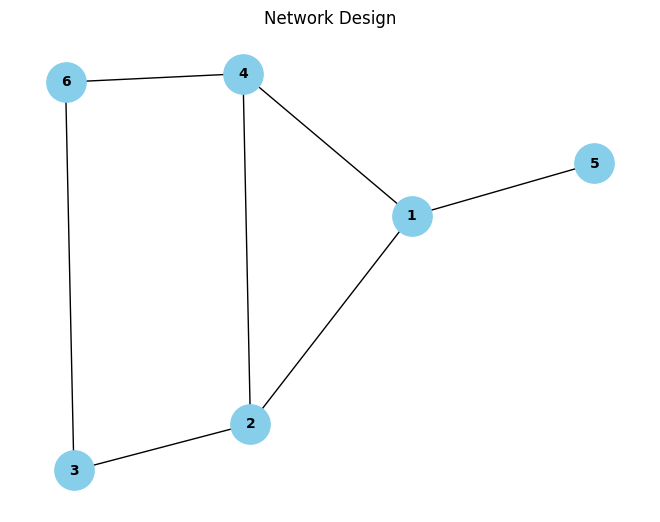

In [314]:
import networkx as nx
import matplotlib.pyplot as plt

# Add edges from adjacency matrix to list of tuples representing edges
edges = []
for i in selected_edges_indices:
  edges.append(sorted_list[i][0])

print("")
print("The most reliability enhanced network contains the following edges:")
print(edges)
print("It has a cost of " +str(network_cost)+ " and a reliability of " +str(network_reliability))

# Create an empty graph
G = nx.Graph()
# Add edges to the graph
G.add_edges_from(edges)

# Draw the graph
nx.draw(G, with_labels=True, node_color='skyblue', node_size=800, font_size=10, font_weight='bold')
plt.title('Network Design')
plt.show()
